## Imports 

In [12]:
import os
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity


## Load dataset

In [13]:
DATA_DIR = "C:/Users/elswe/OneDrive/سطح المكتب/IRS Project/AIE425_FinalProject_Group 11/AIE425_Intelligent Recommender Systems/SECTION2_Sleep Quality Improvement Recommendation Engine/data"

items_path   = os.path.join(DATA_DIR, "sleep_items.csv")
ratings_path = os.path.join(DATA_DIR, "sleep_ratings.csv")
reviews_path = os.path.join(DATA_DIR, "sleep_reviews.csv")
users_path   = os.path.join(DATA_DIR, "sleep_users.csv")

items   = pd.read_csv(items_path)
ratings = pd.read_csv(ratings_path)
reviews = pd.read_csv(reviews_path)
users   = pd.read_csv(users_path)

print("items:", items.shape)
print("ratings:", ratings.shape)
print("reviews:", reviews.shape)
print("users:", users.shape)

items.head()


items: (520, 8)
ratings: (51488, 5)
reviews: (41111, 8)
users: (5000, 14)


,item_id,name,category,features_json,description,average_rating,num_reviews,launch_date
0,1,Dream Track v1,Mobile Apps,"{""has_sleep_tracking"": true, ""has_meditation"":...","Dream Track v1 is a sleep app with meditation,...",2.84,395,2024-09-07
1,2,SlumberAI v1,Mobile Apps,"{""has_sleep_tracking"": false, ""has_meditation""...","SlumberAI v1 is a sleep app with meditation, t...",2.70,491,2023-05-17
2,3,Restful v1,Mobile Apps,"{""has_sleep_tracking"": true, ""has_meditation"":...","Restful v1 is a sleep app with meditation, tra...",2.60,80,2024-04-17
3,4,Sleep Mastery v1,Mobile Apps,"{""has_sleep_tracking"": false, ""has_meditation""...",Sleep Mastery v1 is a sleep app with meditatio...,3.67,203,2025-04-12
4,5,Zensleep v1,Mobile Apps,"{""has_sleep_tracking"": false, ""has_meditation""...","Zensleep v1 is a sleep app with meditation, tr...",3.68,434,2025-01-08


## User and Item Activity



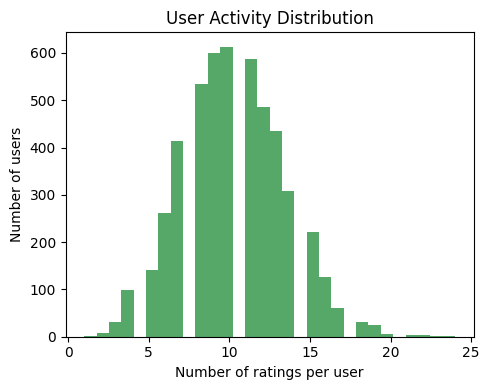

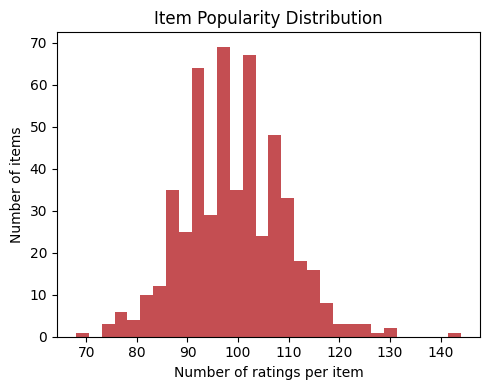

In [14]:
plt.figure(figsize=(5, 4))
ratings["user_id"].value_counts().plot(kind="hist", bins=30, color="#55A868")
plt.xlabel("Number of ratings per user")
plt.ylabel("Number of users")
plt.title("User Activity Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
ratings["item_id"].value_counts().plot(kind="hist", bins=30, color="#C44E52")
plt.xlabel("Number of ratings per item")
plt.ylabel("Number of items")
plt.title("Item Popularity Distribution")
plt.tight_layout()
plt.show()


## Auto-detect column names 

In [15]:
def pick_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

ITEM_ID_COL_items   = pick_col(items,   ["item_id", "asin", "product_id", "id", "ItemId"])
ITEM_ID_COL_ratings = pick_col(ratings, ["item_id", "asin", "product_id", "id", "ItemId"])
USER_ID_COL         = pick_col(ratings, ["user_id", "reviewerID", "customer_id", "uid", "UserId"])
RATING_COL          = pick_col(ratings, ["rating", "overall", "score", "stars", "Rating"])
ITEM_ID_COL_reviews = pick_col(reviews, ["item_id", "asin", "product_id", "id", "ItemId"])
TEXT_COL            = pick_col(reviews, ["review_text", "reviewText", "text", "content", "Review"])

CAT_COL             = pick_col(items,   ["category", "genre", "type", "Category"])
TITLE_COL           = pick_col(items,   ["title", "name", "product_title", "Title"])

print("Detected columns:")
print("ITEM_ID (items):", ITEM_ID_COL_items)
print("ITEM_ID (ratings):", ITEM_ID_COL_ratings)
print("USER_ID:", USER_ID_COL)
print("RATING:", RATING_COL)
print("ITEM_ID (reviews):", ITEM_ID_COL_reviews)
print("TEXT:", TEXT_COL)
print("CATEGORY:", CAT_COL)
print("TITLE:", TITLE_COL)


Detected columns:
ITEM_ID (items): item_id
ITEM_ID (ratings): item_id
USER_ID: user_id
RATING: rating
ITEM_ID (reviews): item_id
TEXT: review_text
CATEGORY: category
TITLE: name


## Build item text 

In [16]:
reviews[TEXT_COL] = reviews[TEXT_COL].fillna("")

item_text_df = (
    reviews.groupby(ITEM_ID_COL_reviews)[TEXT_COL]
    .apply(lambda x: " ".join(x.astype(str)))
    .reset_index()
    .rename(columns={ITEM_ID_COL_reviews: "item_id", TEXT_COL: "item_text"})
)


items2 = items.copy()
items2 = items2.rename(columns={ITEM_ID_COL_items: "item_id"})


items_merged = items2.merge(item_text_df, on="item_id", how="left")
items_merged["item_text"] = items_merged["item_text"].fillna("")

items_merged[["item_id", "item_text"] + ([TITLE_COL] if TITLE_COL else [])].head()


,item_id,item_text,name
0,1,Didn't help much with my Early Morning Awakeni...,Dream Track v1
1,2,Absolutely amazing! Fell asleep faster and sle...,SlumberAI v1
2,3,Only slight improvement if any. Likely won't u...,Restful v1
3,4,Worth every penny. I've tried everything and t...,Sleep Mastery v1
4,5,Doesn't live up to the hype. Poor value. Custo...,Zensleep v1


## TF-IDF features 

In [17]:
tfidf = TfidfVectorizer(
    stop_words="english",
    max_features=5000,
    ngram_range=(1,2)
)

X_text = tfidf.fit_transform(items_merged["item_text"])
X_text.shape


(520, 2388)

## Add additional features

In [18]:
ratings2 = ratings.rename(columns={ITEM_ID_COL_ratings: "item_id", USER_ID_COL: "user_id", RATING_COL: "rating"})


item_avg = ratings2.groupby("item_id")["rating"].mean().reset_index().rename(columns={"rating": "avg_rating"})
items_feat = items_merged.merge(item_avg, on="item_id", how="left")
items_feat["avg_rating"] = items_feat["avg_rating"].fillna(items_feat["avg_rating"].mean())


if CAT_COL and CAT_COL in items_feat.columns:
    ohe = OneHotEncoder(handle_unknown="ignore")
    X_cat = ohe.fit_transform(items_feat[[CAT_COL]].fillna("Unknown"))
else:
    X_cat = csr_matrix((len(items_feat), 0))

X_num = csr_matrix(items_feat[["avg_rating"]].values)


X_item = hstack([X_text, X_cat, X_num]).tocsr()
X_item.shape


(520, 2398)

## User Profile-Weighted Average by rating

In [19]:
item_to_idx = {iid: i for i, iid in enumerate(items_feat["item_id"].values)}

def build_user_profile(user_id):
    ur = ratings2[ratings2["user_id"] == user_id]
    ur = ur[ur["item_id"].isin(item_to_idx)]
    if ur.empty:
        return None
    
    idxs = ur["item_id"].map(item_to_idx).values
    weights = ur["rating"].values.astype(float)
    

    user_vec = X_item[idxs].multiply(weights[:, None]).sum(axis=0) / (weights.sum() + 1e-9)
    return csr_matrix(user_vec)


## Cold start - Popular items strategy

In [20]:
popular_items = (
    ratings2.groupby("item_id")["rating"]
    .mean()
    .sort_values(ascending=False)
    .head(20)
    .index
    .tolist()
)

popular_items[:10]


[40, 495, 62, 342, 442, 247, 490, 132, 378, 303]

## Recommend using Cosine Similarity

In [21]:
def recommend_content_based(user_id, top_n=10):
    profile = build_user_profile(user_id)
    if profile is None:
        rec = items_feat[items_feat["item_id"].isin(popular_items)].copy()
        rec["score"] = np.nan
        return rec.head(top_n)
    
    sims = cosine_similarity(profile, X_item).ravel()
    
    rated = set(ratings2[ratings2["user_id"] == user_id]["item_id"].tolist())
    
    df = items_feat[["item_id"]].copy()
    if TITLE_COL and TITLE_COL in items_feat.columns:
        df["title"] = items_feat[TITLE_COL]
    if CAT_COL and CAT_COL in items_feat.columns:
        df["category"] = items_feat[CAT_COL]
        
    df["score"] = sims
    df = df[~df["item_id"].isin(rated)]
    df = df.sort_values("score", ascending=False).head(top_n)
    return df


user_example = ratings2["user_id"].iloc[0]
recommend_content_based(user_example, top_n=10)


,item_id,title,category,score
239,240,Premium Sleep Solution 240,Bedding & Accessories,0.971844
246,247,Premium Sleep Solution 247,Bedding & Accessories,0.971703
479,480,Premium Sleep Solution 480,Therapy & Counseling,0.971370
234,235,Premium Sleep Solution 235,Bedding & Accessories,0.970899
270,271,Premium Sleep Solution 271,Bedding & Accessories,0.970612
489,490,Premium Sleep Solution 490,Therapy & Counseling,0.970477
255,256,Premium Sleep Solution 256,Bedding & Accessories,0.969570
253,254,Premium Sleep Solution 254,Bedding & Accessories,0.969441
277,278,Premium Sleep Solution 278,Bedding & Accessories,0.969334
492,493,Premium Sleep Solution 493,Therapy & Counseling,0.969273


In [22]:
recommend_content_based(user_example, top_n=20)

,item_id,title,category,score
239,240,Premium Sleep Solution 240,Bedding & Accessories,0.971844
246,247,Premium Sleep Solution 247,Bedding & Accessories,0.971703
479,480,Premium Sleep Solution 480,Therapy & Counseling,0.971370
234,235,Premium Sleep Solution 235,Bedding & Accessories,0.970899
270,271,Premium Sleep Solution 271,Bedding & Accessories,0.970612
489,490,Premium Sleep Solution 490,Therapy & Counseling,0.970477
255,256,Premium Sleep Solution 256,Bedding & Accessories,0.969570
253,254,Premium Sleep Solution 254,Bedding & Accessories,0.969441
277,278,Premium Sleep Solution 278,Bedding & Accessories,0.969334
492,493,Premium Sleep Solution 493,Therapy & Counseling,0.969273


## Item-based kNN

In [23]:
S_item = cosine_similarity(X_item)

def knn_predict_rating(user_id, target_item_id, k=10):
    if target_item_id not in item_to_idx:
        return None
    
    u = ratings2[ratings2["user_id"] == user_id]
    if u.empty:
        return None
    
    target_idx = item_to_idx[target_item_id]
    sim_vec = S_item[target_idx]
    
    top_idx = np.argsort(sim_vec)[::-1]
    top_idx = [i for i in top_idx if i != target_idx][:k]
    
    rated_map = dict(zip(u["item_id"], u["rating"]))
    scores, weights = [], []
    
    for i in top_idx:
        iid = items_feat.iloc[i]["item_id"]
        if iid in rated_map:
            scores.append(rated_map[iid])
            weights.append(sim_vec[i])
    
    if len(scores) == 0:
        return None
    
    return float(np.average(scores, weights=np.array(weights)+1e-9))


## kNN recommendations (rank by predicted rating)

In [24]:
def recommend_knn(user_id, top_n=10, k=10):
    rated = set(ratings2[ratings2["user_id"] == user_id]["item_id"].tolist())
    
    preds = []
    for iid in items_feat["item_id"].values:
        if iid in rated:
            continue
        p = knn_predict_rating(user_id, iid, k=k)
        if p is not None:
            preds.append((iid, p))
    
    preds = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    
    df = pd.DataFrame(preds, columns=["item_id", "pred_rating"])
    if TITLE_COL and TITLE_COL in items_feat.columns:
        df = df.merge(items_feat[["item_id", TITLE_COL]].rename(columns={TITLE_COL:"title"}), on="item_id", how="left")
    return df

recommend_knn(user_example, top_n=10, k=10)


,item_id,pred_rating,title
0,14,5.0,Relax & Restore v2
1,38,5.0,SleepWell v4
2,286,5.0,Breathing Technique Workshop
3,288,5.0,CBT-I Program
4,312,5.0,CBT-I Program
5,319,5.0,Sleep Psychology Course
6,325,5.0,Mindfulness Training
7,328,5.0,CBT-I Program
8,329,5.0,Meditation Course
9,331,5.0,Yoga for Sleep


## Compare Content-Based vs kNN

In [25]:
cb = recommend_content_based(user_example, top_n=10)
knn = recommend_knn(user_example, top_n=10, k=10)

print("Content-Based Top10")
display(cb)

print("kNN Top10")
display(knn)


Content-Based Top10


,item_id,title,category,score
239,240,Premium Sleep Solution 240,Bedding & Accessories,0.971844
246,247,Premium Sleep Solution 247,Bedding & Accessories,0.971703
479,480,Premium Sleep Solution 480,Therapy & Counseling,0.971370
234,235,Premium Sleep Solution 235,Bedding & Accessories,0.970899
270,271,Premium Sleep Solution 271,Bedding & Accessories,0.970612
489,490,Premium Sleep Solution 490,Therapy & Counseling,0.970477
255,256,Premium Sleep Solution 256,Bedding & Accessories,0.969570
253,254,Premium Sleep Solution 254,Bedding & Accessories,0.969441
277,278,Premium Sleep Solution 278,Bedding & Accessories,0.969334
492,493,Premium Sleep Solution 493,Therapy & Counseling,0.969273


kNN Top10


,item_id,pred_rating,title
0,14,5.0,Relax & Restore v2
1,38,5.0,SleepWell v4
2,286,5.0,Breathing Technique Workshop
3,288,5.0,CBT-I Program
4,312,5.0,CBT-I Program
5,319,5.0,Sleep Psychology Course
6,325,5.0,Mindfulness Training
7,328,5.0,CBT-I Program
8,329,5.0,Meditation Course
9,331,5.0,Yoga for Sleep


## Numerical Example

In [26]:
docs = {
    "A": "memory foam mattress soft comfortable",
    "B": "firm mattress good back support",
    "C": "cooling pillow gel comfortable"
}
ex_df = pd.DataFrame({"item": list(docs.keys()), "text": list(docs.values())})

vec = TfidfVectorizer()
X = vec.fit_transform(ex_df["text"])


w = np.array([5,4], dtype=float)
user_vec = (X[0]*w[0] + X[2]*w[1]) / w.sum()

scores = cosine_similarity(user_vec, X).ravel()
ex_df["score"] = scores
ex_df.sort_values("score", ascending=False)


,item,text,score
0,A,memory foam mattress soft comfortable,0.816837
2,C,cooling pillow gel comfortable,0.692846
1,B,firm mattress good back support,0.096698
